In [37]:
from TestSet import read_Chao, read_Tsiligirides, TestInstance
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
Tsiligirides = read_Tsiligirides()
Chao = read_Chao()

In [14]:
sum([len(Tsiligirides[i]) for i in Tsiligirides] + [len(Chao[i]) for i in Chao])

387

# TOP helper functions

In [4]:
def route_cost(cost_matrix: np.ndarray, route: list[int]):
    """Compute the cost of a route given a cost matrix."""
    return cost_matrix[
        route[:-1], route[1:]
    ].sum()

In [122]:
def route_reward(profit_vector: np.ndarray, route: list[int]):
    """Compute the reward of a route given a profit vector."""
    return profit_vector[route].sum()

In [111]:
def feasible(instance: TestInstance, route: list[int]) -> list:
    """Return feasible stops from a given route.
    
    Args:
        - instance: TestInstance
        - route: list of indexes
    
    Stops are feasible if:
    - route cost + stop cost <= T_max, and
    """
    if not type(instance) is TestInstance:
        raise TypeError
    
    s = route[-1]
    
    # Check if route has ended. 
    if s == instance.N - 1:
        return []
    
    # Route has not ended, continue.
    r_cost = route_cost(instance.C, route)
    feasible_mask = (
        # Add costs source + depot + route cost
        instance.C[s] + instance.C[-1] + r_cost <= instance.tmax
    )
    feasible_stops = np.argsort(np.where(feasible_mask, instance.C[route[-1]], np.inf))
    return np.setdiff1d( # Remove routed stops
        np.setdiff1d( # Remove unfeasible stops
            feasible_stops,
            (~feasible_mask).nonzero(),
            assume_unique=True, # No sorting
        ),
        instance.routed.nonzero(),
        assume_unique=True, # No sorting
    )

In [279]:
def two_opt(cost_matrix: np.ndarray, route: list[int]):
    """Improve a route using the two-opt edge exchange method.
    
    Source: https://stackoverflow.com/questions/53275314/2-opt-algorithm-to-solve-the-travelling-salesman-problem-in-python
    """
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i+1, len(route)):
                if j - i == 1: continue # changes nothing, skip then
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                if (
                    route_cost(cost_matrix, new_route) < route_cost(cost_matrix, best)
                ):
                    best = new_route
                    improved = True
        route = best
    return best

In [282]:
def or_opt(cost_matrix: np.ndarray, route: list[int]):
    """Improve a route using the Or-opt (restricted 3-opt) exchange method"""
    pass

In [270]:
def plot_route(instance: TestInstance, route: list[int], figsize=(10, 10)):
    """Plot a single route on the instance graph."""
    G = nx.DiGraph()
    G.add_nodes_from(
        (x, {"weight": p}) for x, p in zip(list(range(instance.N)), instance.P)
    )
    G.add_weighted_edges_from(
        (u, v, c) for u, v, c in zip(route[:-1], route[1:], instance.C[route[:-1], route[1:]])
    )
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(
        G, 
        pos=instance.X, 
        with_labels=True, 
        node_size=200, 
        ax=ax
    )
    nx.draw_networkx_edge_labels(
        G, 
        pos=instance.X, 
        edge_labels={(i[0], i[1]): f'{i[2]["weight"]:.1f}' for i in G.edges(data=True)}
    )
    plt.title(f"Reward: {route_reward(instance.P, route):.2f}, "
              f"Cost: {route_cost(instance.C, route):.2f}, "
              f"T_max: {instance.tmax:.0f}")
    return fig, ax

# Augmented Large Neighbourhood Search

## Pseudo-Code

Parameters:
- Max iterations $I_\max$
- Number of solutions $N$

1. Construct an initial solution $s^*$ (**Algorithm 1**)
2. Add $s^*$ to the solution pool $S$ 
3. Until $I_\max$
    1. Destroy routes (**Algorithm 2**)
    2. Repair routes (**Algorithm 3**)
    3. Insert maximum number of unrouted stops (**Algorithm 4**)
    4. Improve the solution until no further improvement (**Algorithm 5**)
    5. (Terminate if the solution is the upper bound, for existing optimal solutions) (**Algorithm D**)
    6. Update the best solution $S^*$ if there is improvement
    7. Replace the worst solution $S$ if
        1. The current solution is not in the pool
        2. The pool is full
        3. The pool's worst solution is worse than the current solution
    8. Insert the new solution in $S$ if
        1. $S$ is not full
        2. The current solution is not in $S$

# Algorithm A: Local Search Improvement
> [The algorithm] consists of popular inter-route and intraroute improvement methods. In the 1-1 improvement method, a stop from a route is exchanged with a stop from another route. The exchange is accepted if it is feasible for both routes and the total travel distance of the two routes is reduced. In the 1-0 improvement method, a stop from a route is moved into another route and improvement is tested. Similarly, the 2-1 improvement method exchanges two stops from a route with one stop from another route. The intra-route improvement algorithm consists of well-known 2opt edge exchange method and Or-opt improvement method (Or, 1976). The improvement methods repeat until no further improvement is possible.

# Algorithm B: Insertion Method
> In the insertion method, each unrouted stop is tested to be inserted into a route and the unrouted feasible stop that has the smallest distance increase due to the stop insertion is iteratively selected and inserted. The insertion procedure is repeated until no additional stops can be inserted to any of the routes

# Algorithm C: Shifting and Insertion Method
> [A]ttempts are made to move stops from a route into other routes to make room for unrouted stops. [...] [A]ll possible unrouted stops are inserted into a route; [Then, the algorithm attempts to add as many unrouted stops as possible to the route].

# Algorithm D1: Random Replacement Method
> The algorithm exchanges routed stops with unrouted stops to improve the solution’s total reward value. [...] [A] random number is generated for each iteration and this number determines the number of stops that will be removed from the route. [...] [The] stops to be deleted are selected randomly and their total rewards are compared with the total rewards of all unrouted stops. [...] [If] the value of the unrouted stops is less than the value of the deleted stops, that iteration will be skipped because there is no potential benefit to the exchange. Otherwise [...] the selected stops are deleted from the route and unrouted stops are randomly inserted. In this step, each unrouted stop is tested to determine if the insertion is feasible. [...] [If] the total rewards of the newly inserted stops are larger than the total rewards of the deleted stops, the replacement for the route will be accepted and the next route will be tested. The above procedures repeat for $R_\max$ iterations for each route.

# Algorithm D2: Full-Enumeration Replacement Method
> Instead of randomly selecting $d_r$ routed stops and randomly replacing current stops, the full-enumeration replacement algorithm tests all routed stops for a 1-1 replacement and then a 1-2 replacement. The 1-1 replacement exchanges a routed stop with an unrouted stop and repeats until there is no improvement. Then 1-2 replacement is tested checking the replacement of a routed stop with two unrouted stops. The replacement is executed when the solution rewards are increased or the route travel time is decreased without rewards loses.

# Algorithm E: Known upper bound termination
> [The] algorithm terminates if the improved solution is the upper bound, where the upper bound terminate condition is applied for those instances in which the exact optimal solutions are reported by Boussier, Feillet, and Gendreau (2007). [...] Note that Dang et al. (2011) also used the same upper bound terminate condition.

# Algorithm 1: Greedy Construction
> From the current stop, $c_L$, the feasible stop that has the smallest distance divided by reward is selected as the next stop. The procedure repeats until no more stops can be added to the route. [...] When there is improvement, i.e., the total route travel distance is reduced, additional stops are inserted. [...] [T]he algorithm attempts to add as many unrouted stops as possible to the route [...].

In [271]:
def construction(instance: TestInstance):
    # Initialise instance
    instance = deepcopy(instance)
    instance.routed = np.zeros(instance.N, dtype=bool) # Remove start and stop
    instance.routed[0] = True
    instance.solution = {team: [0] for team in range(instance.m)}
    
    # For each team
    for team in range(instance.m):
        # Repeat while there is a feasible unrouted stop
        while len(feasible_list := feasible(instance, instance.solution[team])) > 0:
            # Greedy feasible stop
            c = feasible_list[0]
            
            # Add feasible stop with lowest distance to the route
            instance.solution[team] += [c]
            
            # Set c_N routed
            if c != instance.N - 1:
                instance.routed[c] = True
    
    # Improve routes using the intra-route improvement
    
    return instance

In [272]:
# Instance
instance = Chao["Set_100_234"][1]

# Set all stops unrouted
solution = construction(instance).solution

(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reward: 572.00, Cost: 79.78, T_max: 80'}>)

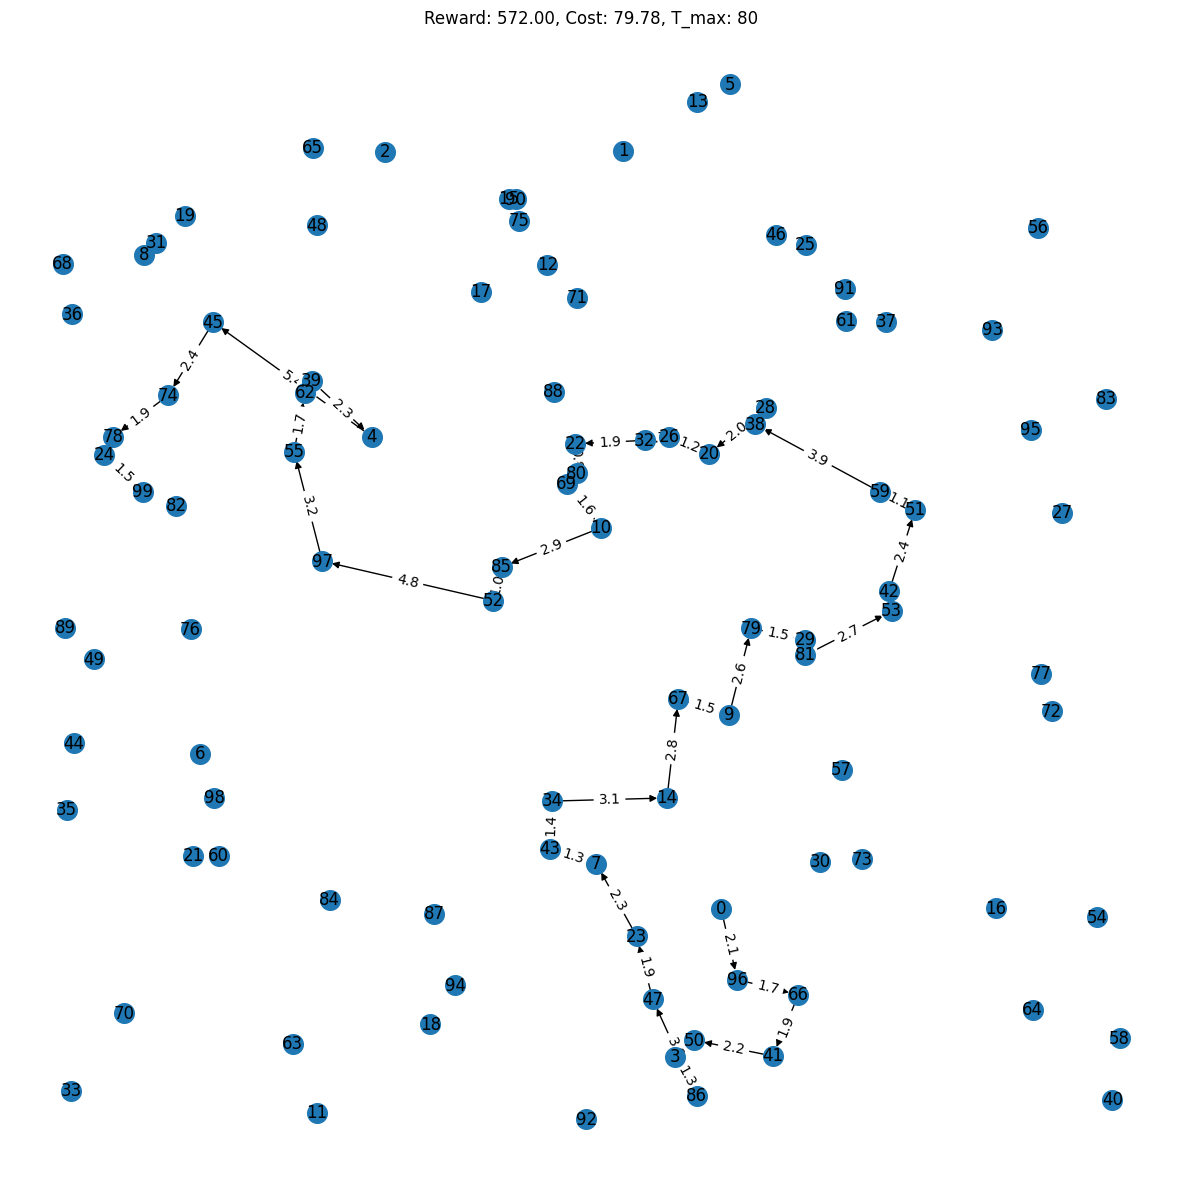

In [280]:
plot_route(instance, solution[0], figsize=(15, 15))

(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reward: 572.00, Cost: 76.19, T_max: 80'}>)

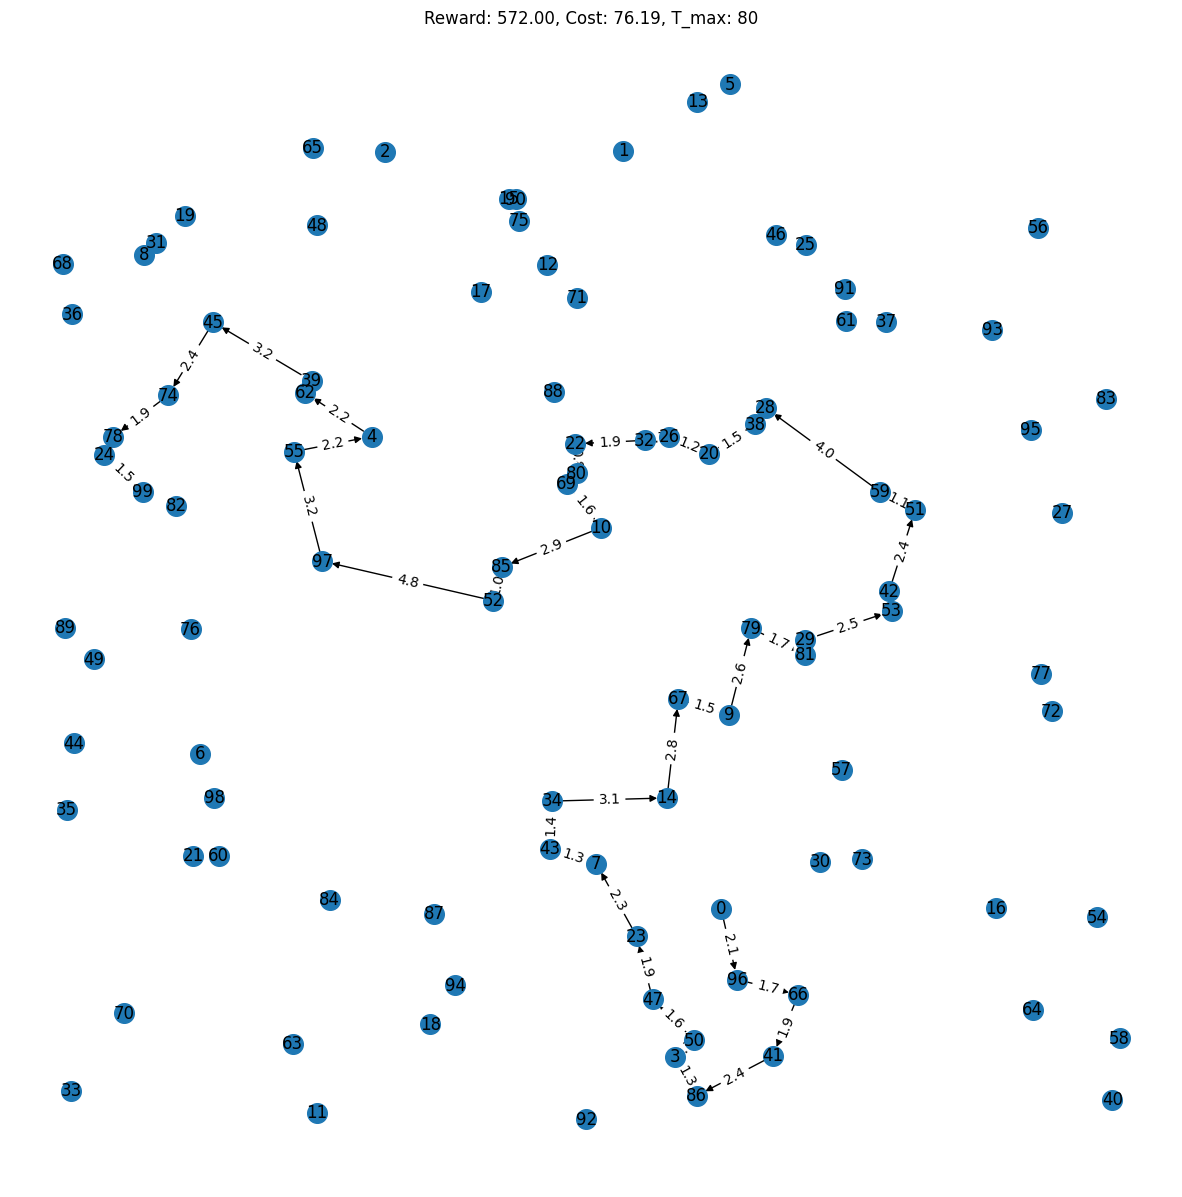

In [281]:
plot_route(instance, two_opt(instance.C, solution[0]), figsize=(15, 15))

# Algorithm 2: Destroy routes
> [...] $k$ stops are removed from the selected solution according to the remove criterion. Three remove criterions are designed for solution diversification: random remove, biggest remove and smallest remove. In the random remove, $k$ stops will be randomly selected and removed from the current solution. The biggest remove will remove the $k$ stops which have the biggest rewards and the $k$ smallest rewards stops will be removed under the smallest remove criterion similarly. The three remove criterions are randomly selected in each iteration.

# Algorithm 3: Repair routes
> [...] [The] solution with stops removed is repaired via two improvement methods until there are no more improvements [...].

The algorithms mentionned are the Local Search Improvement (A) and Shifting and Insertion methods (C)

# Algorithm 4: Maximum re-insertion
> In the insertion method, each unrouted stop is tested to be inserted into a route and the unrouted feasible stop that has the smallest distance increase due to the stop insertion is iteratively selected and inserted. The insertion procedure is repeated until no additional stops can be inserted to any of the routes.

# Algorithm 5: Maximum improvement
> [The] updated solution is further improved not only by the previous two improvement methods, but also with two replacement method [...].

The two replacement methods are the Random Replacement (D1) and the Full-Enumeration Replacement (D2) methods.